#  Import Dependencies

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime
from tqdm import tqdm


In [ ]:
#@title Record Each Cell's Execution Time
!pip install ipython-autotime

%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00
time: 350 µs (started: 2023-12-09 17:16:52 +00:00)


In [ ]:
!pip install -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.2 MB/s eta 0:00:00
time: 7.75 s (started: 2023-12-09 17:16:52 +00:00)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 18.1 ms (started: 2023-12-09 17:17:00 +00:00)


In [ ]:
!mkdir "logs/"
!ls

logs  sample_data
time: 237 ms (started: 2023-12-09 17:17:00 +00:00)


In [ ]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

time: 135 ms (started: 2023-12-09 17:17:00 +00:00)


# Download and preprocess data


## Dowload and unzip

In [ ]:
!gdown 1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD

Downloading...
From: https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
To: /content/ml1m.zip
100% 105M/105M [00:00<00:00, 230MB/s] 
time: 2.14 s (started: 2023-12-09 17:17:00 +00:00)


In [ ]:
!unzip -qq ml1m.zip -d ml1m

time: 1.92 s (started: 2023-12-09 17:17:03 +00:00)


Read CSV

In [ ]:
users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

time: 7.5 s (started: 2023-12-09 17:17:05 +00:00)


##Extract feature

In [ ]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

time: 107 ms (started: 2023-12-09 17:17:12 +00:00)


In [ ]:
movies_train

,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,ml1m/content/dataset/ml1m-images/3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,ml1m/content/dataset/ml1m-images/1901.jpg
...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,ml1m/content/dataset/ml1m-images/2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,ml1m/content/dataset/ml1m-images/3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,ml1m/content/dataset/ml1m-images/1832.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,ml1m/content/dataset/ml1m-images/657.jpg


time: 68.5 ms (started: 2023-12-09 09:32:50 +00:00)


One-hot labels genre

In [ ]:
df_train = movies_train.drop(columns = ['genre','id'])
genres_df = pd.DataFrame(movies_train['genre'].explode().unique(), columns=['genre'])
for genre in genres_df['genre']:
    df_train[genre] = movies_train['genre'].apply(lambda x: 1 if genre in x else 0)

df_test = movies_test.drop(columns = ['genre','id'])
genres_df = pd.DataFrame(movies_train['genre'].explode().unique(), columns=['genre'])
for genre in genres_df['genre']:
    df_test[genre] = movies_test['genre'].apply(lambda x: 1 if genre in x else 0)


time: 91.2 ms (started: 2023-12-09 17:18:03 +00:00)


In [ ]:
# Kết hợp dữ liệu từ cả hai bảng
merged_df = pd.merge(ratings, users, on='userid')

# Tổng hợp số lượng nam và nữ theo từng film
gender_counts = merged_df.groupby(['movieid', 'gender']).size().unstack(fill_value=0)

# Tạo DataFrame mới từ kết quả
gender_df = pd.DataFrame(gender_counts.to_records())

# Đổi tên cột để thể hiện ý nghĩa
gender_df.columns = ['movieid', 'female_count', 'male_count']

# Xuất kết quả
print(gender_df)


      movieid  female_count  male_count
0           1           591        1486
1           2           176         525
2           3           136         342
3           4            85          85
4           5           108         188
...       ...           ...         ...
3701     3948           231         631
3702     3949            80         224
3703     3950            10          44
3704     3951            17          23
3705     3952           105         283

[3706 rows x 3 columns]
time: 349 ms (started: 2023-12-09 17:31:58 +00:00)


In [ ]:
film_rating_counts = ratings.groupby(['movieid', 'rating']).size().unstack(fill_value=0)

# Tạo DataFrame mới từ kết quả
rating_df = pd.DataFrame(film_rating_counts.to_records())

# Đổi tên cột để thể hiện ý nghĩa
rating_df.columns = ['movieid', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']

# Xuất kết quả
print(rating_df)

      movieid  rating_1  rating_2  rating_3  rating_4  rating_5
0           1        16        61       345       835       820
1           2        42       108       266       237        48
2           3        44        95       191       105        43
3           4        21        47        65        31         6
4           5        28        54       118        80        16
...       ...       ...       ...       ...       ...       ...
3701     3948        35        75       222       367       163
3702     3949         9        15        40       108       132
3703     3950         2         5        14        21        12
3704     3951         1         3         9        13        14
3705     3952         9        26        89       181        83

[3706 rows x 6 columns]
time: 48.1 ms (started: 2023-12-09 17:32:01 +00:00)


In [ ]:
merged_df = pd.merge(ratings, users, on='userid')

# Phân loại người xem theo khoảng độ tuổi
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels)

# Tổng hợp số lượng người xem theo nhóm độ tuổi cho mỗi film
age_counts = merged_df.groupby(['movieid', 'age_group']).size().unstack(fill_value=0)

# Tạo DataFrame mới từ kết quả
age_df = pd.DataFrame(age_counts.to_records())

# Xuất kết quả
print(age_df)

      movieid  18-25  26-35  36-45  46-55  56-65  65+
0           1    790    423    143    108     53    0
1           2    261    143     52     45     10    0
2           3    176     81     33     33     30    0
3           4     77     28     12      7      4    0
4           5    117     58     18     20      3    0
...       ...    ...    ...    ...    ...    ...  ...
3701     3948    335    145     64     43     35    0
3702     3949    131     44     16     11      7    0
3703     3950     19      6      4      5      3    0
3704     3951     12      9      8      3      4    0
3705     3952    146     71     30     46     24    0

[3706 rows x 7 columns]
time: 291 ms (started: 2023-12-09 17:32:04 +00:00)


In [ ]:
merged_df = pd.merge(ratings, users, on='userid')

# Phân loại người xem theo nghề nghiệp
bins = list(range(0, 21))
labels = [f'Occupation_{i}' for i in bins[:-1]]
merged_df['occupation_group'] = pd.cut(merged_df['occupation'], bins=bins, labels=labels, right=False)

# Tổng hợp số lượng người xem theo nhóm nghề nghiệp cho mỗi film
occupation_counts = merged_df.groupby(['movieid', 'occupation_group']).size().unstack(fill_value=0)

# Tạo DataFrame mới từ kết quả
occupation_df = pd.DataFrame(occupation_counts.to_records())

# Xuất kết quả
print(occupation_df)

      movieid  Occupation_0  Occupation_1  Occupation_2  Occupation_3  \
0           1           270           157            86            67   
1           2           104            53            34            21   
2           3            67            37            18            22   
3           4            28            21             6             6   
4           5            37            26             9            14   
...       ...           ...           ...           ...           ...   
3701     3948            97            56            38            26   
3702     3949            42            23            18             8   
3703     3950            10             3             3             2   
3704     3951             8             3             1             0   
3705     3952            48            33            23             9   

      Occupation_4  Occupation_5  Occupation_6  Occupation_7  Occupation_8  \
0              297            39            7

In [ ]:
user_df = pd.merge(gender_df, age_df, on='movieid')
user_df = pd.merge(user_df, occupation_df, on='movieid')
user_rating_df = pd.merge(rating_df,user_df, on='movieid')
# Xuất DataFrame kết quả
print(user_rating_df)

      movieid  rating_1  rating_2  rating_3  rating_4  rating_5  female_count  \
0           1        16        61       345       835       820           591   
1           2        42       108       266       237        48           176   
2           3        44        95       191       105        43           136   
3           4        21        47        65        31         6            85   
4           5        28        54       118        80        16           108   
...       ...       ...       ...       ...       ...       ...           ...   
3701     3948        35        75       222       367       163           231   
3702     3949         9        15        40       108       132            80   
3703     3950         2         5        14        21        12            10   
3704     3951         1         3         9        13        14            17   
3705     3952         9        26        89       181        83           105   

      male_count  18-25  26

In [ ]:
user_rating_features = user_rating_df.drop(columns = 'movieid').columns

time: 11.1 ms (started: 2023-12-09 17:46:10 +00:00)


In [ ]:
user_rating_features

Index(['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5',
       'female_count', 'male_count', '18-25', '26-35', '36-45', '46-55',
       '56-65', '65+', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19'],
      dtype='object')

time: 3.81 ms (started: 2023-12-09 17:46:19 +00:00)


In [ ]:
df_train.drop(columns = ['movieid','title','img_path']).sum()

Drama          1294
Sci-Fi          228
Thriller        386
Action          413
Adventure       235
Comedy          953
Crime           180
Documentary      97
Animation        84
Children's      203
Romance         377
Horror          268
War             118
Musical         101
Film-Noir        38
Mystery          88
Western          54
Fantasy          61
dtype: int64

time: 10.4 ms (started: 2023-12-09 09:35:45 +00:00)


There are some missing images in data, we will drop it out dataset

In [ ]:
for i in tqdm(range(df_train.shape[0])):
    path = df_train['img_path'][i]
    if not os.path.isfile(path):
      df_train=df_train.drop(axis=0, index=i)

for i in tqdm(range(df_test.shape[0])):
    path = df_test['img_path'][i]
    if not os.path.isfile(path):
      df_test=df_test.drop(axis=0, index=i)


100%|██████████| 777/777 [00:00<00:00, 6226.71it/s]

time: 770 ms (started: 2023-12-09 08:12:35 +00:00)


In [ ]:
df_train = pd.merge(df_train, user_rating_df, on='movieid')

time: 21.1 ms (started: 2023-12-09 17:43:09 +00:00)


In [ ]:
df_train.columns

Index(['movieid', 'title', 'img_path', 'Drama', 'Sci-Fi', 'Thriller', 'Action',
       'Adventure', 'Comedy', 'Crime', 'Documentary', 'Animation',
       'Children's', 'Romance', 'Horror', 'War', 'Musical', 'Film-Noir',
       'Mystery', 'Western', 'Fantasy', 'rating_1', 'rating_2', 'rating_3',
       'rating_4', 'rating_5', 'female_count', 'male_count', '18-25', '26-35',
       '36-45', '46-55', '56-65', '65+', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19'],
      dtype='object')

time: 7.21 ms (started: 2023-12-09 17:44:16 +00:00)


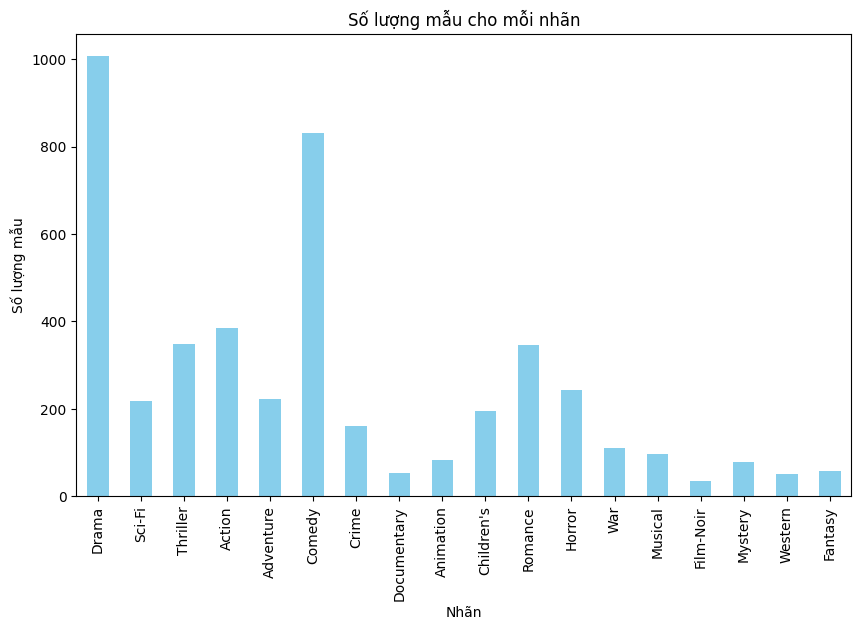

time: 329 ms (started: 2023-12-09 08:12:36 +00:00)


In [ ]:
class_counts = df_train.drop(columns = ['movieid','title','img_path']).sum()
class_counts

# Hiển thị đồ thị cột
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng mẫu cho mỗi nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
plt.show()

##Augmentation Data

### Record the labels

In [ ]:
LABELS= genres_df['genre'].to_list()
print(LABELS)

['Drama', 'Sci-Fi', 'Thriller', 'Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Animation', "Children's", 'Romance', 'Horror', 'War', 'Musical', 'Film-Noir', 'Mystery', 'Western', 'Fantasy']
time: 1.35 ms (started: 2023-12-09 08:12:36 +00:00)


### Augmentaion data
The labels which has min quantity will be doubled


In [ ]:
df_train['is_aug']=0
def double_sample(num_loop, df_train):
  for i in range(num_loop):
    label_counts = df_train[LABELS].sum()
    labels_to_double = label_counts.idxmin()
    double_count = label_counts.min() * 2
    new_samples = df_train[df_train[labels_to_double] == 1].sample(double_count, replace=True)
    new_samples['is_aug'] = 1
    # new_samples['Drama'] = new_samples['Comedy'] = 0
    df_train = pd.concat([df_train, new_samples], ignore_index=True)
  return df_train
df_train = double_sample(14,df_train)

time: 50.5 ms (started: 2023-12-09 08:12:36 +00:00)


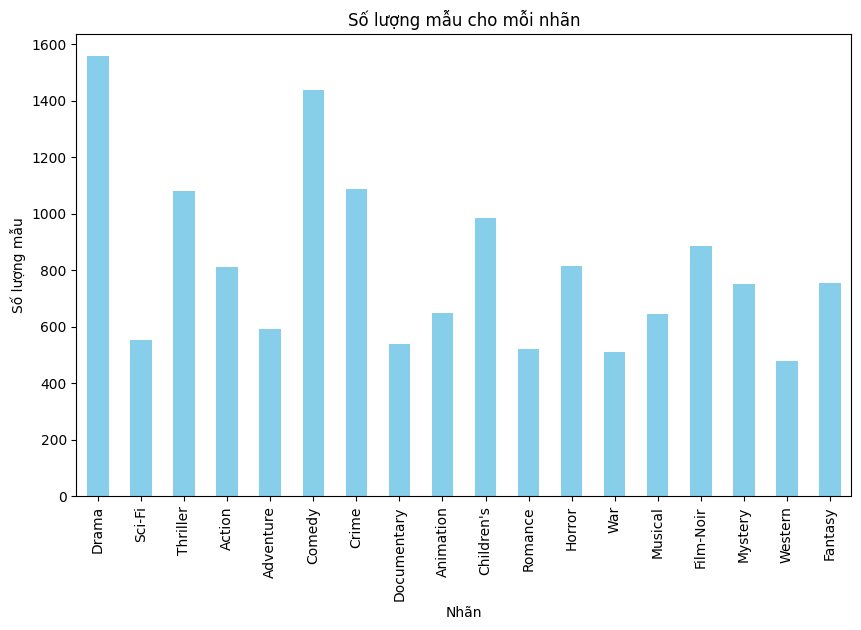

time: 270 ms (started: 2023-12-09 08:12:36 +00:00)


In [ ]:
class_counts = df_train.drop(columns = ['movieid','title','img_path','is_aug']).sum()
class_counts

# Hiển thị đồ thị cột
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng mẫu cho mỗi nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
plt.show()

In [ ]:
df_train.drop(columns = ['movieid', 'title', 'img_path']).sum()

Drama          1557
Sci-Fi          553
Thriller       1079
Action          812
Adventure       591
Comedy         1438
Crime          1086
Documentary     537
Animation       650
Children's      983
Romance         520
Horror          814
War             510
Musical         646
Film-Noir       884
Mystery         751
Western         477
Fantasy         755
is_aug         4110
dtype: int64

time: 5.96 ms (started: 2023-12-09 08:12:36 +00:00)


In [ ]:
df_train

,movieid,title,img_path,Drama,Sci-Fi,Thriller,Action,Adventure,Comedy,Crime,...,Children's,Romance,Horror,War,Musical,Film-Noir,Mystery,Western,Fantasy,is_aug
0,1650,Washington Square (1997),ml1m/content/dataset/ml1m-images/1650.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,185,"Net, The (1995)",ml1m/content/dataset/ml1m-images/185.jpg,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1377,Batman Returns (1992),ml1m/content/dataset/ml1m-images/1377.jpg,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3204,"Boys from Brazil, The (1978)",ml1m/content/dataset/ml1m-images/3204.jpg,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2382,Police Academy 5: Assignment: Miami Beach (1988),ml1m/content/dataset/ml1m-images/2382.jpg,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6707,293,"Professional, The (a.k.a. Leon: The Profession...",ml1m/content/dataset/ml1m-images/293.jpg,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
6708,1617,L.A. Confidential (1997),ml1m/content/dataset/ml1m-images/1617.jpg,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
6709,592,Batman (1989),ml1m/content/dataset/ml1m-images/592.jpg,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
6710,3435,Double Indemnity (1944),ml1m/content/dataset/ml1m-images/3435.jpg,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


time: 22.9 ms (started: 2023-12-09 08:12:36 +00:00)


In [ ]:
titles_train = df_train['title'].to_list()
titles_test = df_test['title'].to_list()


time: 918 µs (started: 2023-12-09 08:12:37 +00:00)


In [ ]:
def preprocess_titles(title):
  tok = title.split()
  tok = tok [:-1]
  ret_str = ' '.join(tok)
  return ret_str
for i,title in enumerate(titles_train):
  titles_train[i] = preprocess_titles(title)


time: 12.3 ms (started: 2023-12-09 08:12:37 +00:00)


In [ ]:
from transformers import BertTokenizer
max_length = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tk_titles_train = tokenizer(titles_train, truncation=True, padding='max_length', max_length=max_length, return_tensors="tf")
tk_titles_test = tokenizer(titles_test, truncation=True, padding='max_length', max_length=max_length, return_tensors="tf")

time: 8.1 s (started: 2023-12-09 08:12:37 +00:00)


In [ ]:
input_ids_train = tk_titles_train['input_ids']
attention_mask_train = tk_titles_train['attention_mask']
input_ids_test = tk_titles_test['input_ids']
attention_mask_test = tk_titles_test['attention_mask']

X_titles_train = {'input_ids': input_ids_train, 'attention_mask': attention_mask_train}
X_titles_test =  {'input_ids': input_ids_test, 'attention_mask': attention_mask_test}

time: 757 µs (started: 2023-12-09 08:12:45 +00:00)


In [ ]:
img_path_train = df_train[['img_path', 'is_aug']]
img_path_test = df_test['img_path'].to_list()

time: 3.46 ms (started: 2023-12-09 08:12:45 +00:00)


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 128 , 128
def decode_img(img, is_aug = False):
  #color images
  img = tf.image.decode_jpeg(img, channels=3)
  if is_aug:
    img = augment_img(img)
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32)
  #resize
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

time: 636 µs (started: 2023-12-09 08:12:45 +00:00)


In [ ]:
import imgaug.augmenters as iaa
def augment_img(img):
    # Tạo một augmenter với các biến đổi ngẫu nhiên
    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),        # Flip trái phải với xác suất 0.5
        # iaa.Affine(rotate=(-180,180)),  # Xoay ảnh ngẫu nhiên trong khoảng -45 đến 45 độ
        iaa.Affine(scale=(1, 2))   # Zoom in/out ngẫu nhiên
    ])
    # Áp dụng augmenter cho ảnh
    img = augmenter(image = img.numpy())
    return img

def read_image(path, is_aug = False):
  img = tf.io.read_file(path)
  img = decode_img(img, is_aug)
  return img

time: 1.19 s (started: 2023-12-09 08:12:45 +00:00)


In [ ]:
X_imgs_train = []
X_imgs_test = []

for index, row in df_train.iterrows():
  X_imgs_train.append(read_image(row['img_path'], row['is_aug']))
for path in img_path_test:
  X_imgs_test.append(read_image(path))

X_imgs_train = np.array(X_imgs_train)
X_imgs_test = np.array(X_imgs_test)

time: 30.3 s (started: 2023-12-09 08:12:46 +00:00)


In [ ]:
y_train = df_train[LABELS].to_numpy()
y_test = df_test[LABELS].to_numpy()

time: 3.74 ms (started: 2023-12-09 08:13:16 +00:00)



Convert multi-hot labels to string labels

In [ ]:
def covert_onehot_string_labels(label_string, label_onehot):
    labels = []
    for i, label in enumerate(label_string):
        if label_onehot[i] == 1:
            labels.append(label)
    if len(labels) == 0:
        labels.append("NONE")
    return labels


time: 594 µs (started: 2023-12-09 08:13:16 +00:00)


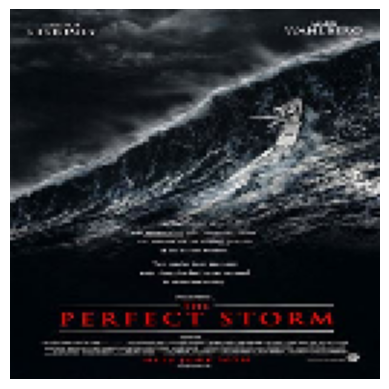

Title: perfect storm, the
Genres ['Thriller', 'Action', 'Adventure']
time: 183 ms (started: 2023-12-09 08:13:16 +00:00)


In [ ]:
index = 1002
plt.imshow(X_imgs_train[index], cmap='gray')  # Assuming a grayscale image, adjust 'cmap' if needed
plt.axis('off')  # Turn off axis labels
plt.show()
input_ids = X_titles_train['input_ids']
decoded_text = tokenizer.decode(input_ids[index], skip_special_tokens=True)
print("Title:", decoded_text)
print("Genres",covert_onehot_string_labels(LABELS,y_train[index]))

In [ ]:
# BATCH_SIZE=64
# X_train = [X_titles_train , X_imgs_train]
# ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# # Mix và lặp lại dữ liệu để đảm bảo đa dạng trong mỗi batch
# ds_train = ds_train.shuffle(buffer_size=len(X_train)).repeat()

# X_test = [X_titles_test , X_imgs_test]
# ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_train))

# ds_train_batched = ds_train.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# ds_test_batched = ds_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

time: 270 µs (started: 2023-12-09 08:13:16 +00:00)


# 2. Create a Keras CNN model by using Transfer learning for images and a simple NN model for titles

## Import VGG16

To train fast, let's use Transfer Learning by importing VGG16

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

time: 996 ms (started: 2023-12-09 08:13:16 +00:00)


## Create the classification model


In [ ]:
number_of_classes = len(LABELS)

time: 416 µs (started: 2023-12-09 08:13:17 +00:00)


### Model for titles classification with BERT

In [ ]:
# Ins
from transformers import TFBertForSequenceClassification
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout

PRETRAINED_MODEL_NAME = 'bert-base-uncased'
bert_model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=number_of_classes)
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='attention_mask')
output = bert_model([input_ids, attention_mask])[0]
output = tf.keras.layers.Dense(number_of_classes, activation='sigmoid')(output)
titles_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 15.8 s (started: 2023-12-09 08:13:17 +00:00)


### Model for images classification


In [ ]:
images_inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3),name = 'image_inputs')
x = base_model(images_inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x)
images_model = keras.Model(images_inputs, outputs)

time: 107 ms (started: 2023-12-09 08:13:33 +00:00)


## Combined 2 model

In [ ]:
from keras.layers import Concatenate, Average
from keras.models import Model


titles_output = titles_model([input_ids, attention_mask])
images_output = images_model(images_inputs)
inp = [images_inputs, [input_ids, attention_mask]]
out = Average()([images_output,titles_output])

# Tạo mô hình tổng hợp
combined_model = Model(inputs = inp, outputs=out)

time: 2.43 s (started: 2023-12-09 08:13:33 +00:00)


# 3. Compile & Train

In [ ]:
combined_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

time: 21.8 ms (started: 2023-12-09 08:13:36 +00:00)


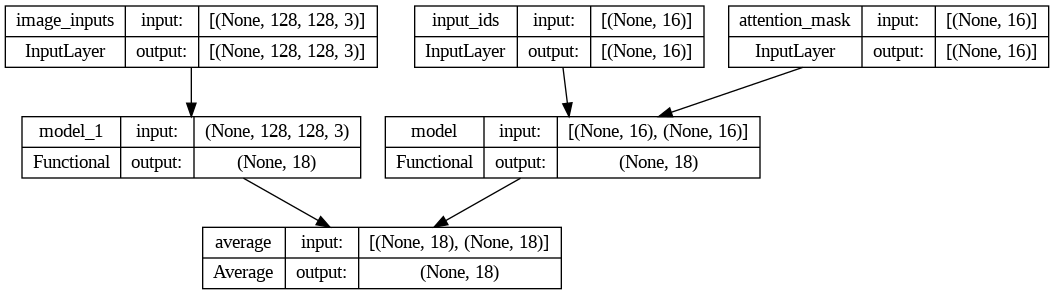

time: 206 ms (started: 2023-12-09 08:13:36 +00:00)


In [ ]:
from keras.utils import plot_model

# Vẽ kiến trúc mô hình
plot_model(combined_model, to_file='model_2.png', show_shapes=True)

## Save model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
checkpoint_path = '/content/gdrive/My Drive/checkpoints/best_model.h5'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.42 s (started: 2023-12-09 08:13:36 +00:00)


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1)

time: 629 µs (started: 2023-12-09 08:13:39 +00:00)


## Train Model

## Combined model

In [ ]:
combined_model.fit(x =[X_imgs_train,X_titles_train] ,y = y_train,batch_size = 64, validation_data=([X_imgs_test,X_titles_test],y_test), epochs=20,callbacks=[checkpoint])

Epoch 1/20
105/105 [==============================] - ETA: 0s - loss: 0.3700 - binary_accuracy: 0.8692
Epoch 1: val_binary_accuracy improved from -inf to 0.90792, saving model to /content/gdrive/My Drive/checkpoints/best_model.h5
105/105 [==============================] - 158s 995ms/step - loss: 0.3700 - binary_accuracy: 0.8692 - val_loss: 0.2774 - val_binary_accuracy: 0.9079
Epoch 2/20
105/105 [==============================] - ETA: 0s - loss: 0.3312 - binary_accuracy: 0.8788
Epoch 2: val_binary_accuracy did not improve from 0.90792
105/105 [==============================] - 36s 345ms/step - loss: 0.3312 - binary_accuracy: 0.8788 - val_loss: 0.2671 - val_binary_accuracy: 0.9079
Epoch 3/20
105/105 [==============================] - ETA: 0s - loss: 0.3169 - binary_accuracy: 0.8788
Epoch 3: val_binary_accuracy did not improve from 0.90792
105/105 [==============================] - 34s 323ms/step - loss: 0.3169 - binary_accuracy: 0.8788 - val_loss: 0.2584 - val_binary_accuracy: 0.9079
Epo

time: 13min 40s (started: 2023-12-09 08:13:39 +00:00)


## Titles model

In [ ]:
titles_model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
plot_model(titles_model, to_file='model_2.png', show_shapes=True)

In [ ]:
titles_model.fit(
    X_titles_train,
    y_train,
    validation_data=(X_titles_test, y_test),
    epochs=20,
    batch_size=64
)

## Images Model

In [ ]:
images_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])


In [ ]:
plot_model(images_model, to_file='model_2.png', show_shapes=True)

In [ ]:
images_model.fit(x = X_imgs_train,y = y_train,batch_size = 64, validation_data=(X_imgs_test,y_test), epochs=20)

# 4. Evaulate the model

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from keras.models import load_model
import numpy as np

# Load mô hình tốt nhất từ tệp 'best_model.h5'
path = '/content/gdrive/My Drive/checkpoints/best_model.h5'
# best_model = load_model(path,custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})
best_model = combined_model
# Dự đoán trên tập kiểm thử
y_pred = best_model.predict([X_imgs_test,X_titles_test])



21/21 [==============================] - 8s 85ms/step
time: 8.37 s (started: 2023-12-09 08:27:40 +00:00)


In [ ]:
thres = 0.2

y_pred_labels = (y_pred > thres).astype(int)

report = classification_report(y_test, y_pred_labels, target_names=LABELS)

print(report)

              precision    recall  f1-score   support

       Drama       0.42      0.88      0.57       248
      Sci-Fi       0.41      0.36      0.39        44
    Thriller       0.28      0.49      0.35       104
      Action       0.26      0.29      0.27        86
   Adventure       0.13      0.16      0.14        43
      Comedy       0.47      0.84      0.60       220
       Crime       0.06      0.07      0.06        27
 Documentary       0.00      0.00      0.00        18
   Animation       0.53      0.38      0.44        21
  Children's       0.22      0.38      0.28        47
     Romance       0.18      0.05      0.08        83
      Horror       0.29      0.46      0.35        67
         War       0.33      0.08      0.13        24
     Musical       0.17      0.36      0.23        11
   Film-Noir       0.10      0.17      0.12         6
     Mystery       0.10      0.06      0.07        18
     Western       0.00      0.00      0.00        10
     Fantasy       0.03    

In [ ]:
y_pred

array([[0.2545507 , 0.08646435, 0.02564724, ..., 0.033298  , 0.05971516,
        0.1924031 ],
       [0.36635888, 0.02703527, 0.044804  , ..., 0.02062108, 0.05455724,
        0.01921746],
       [0.03195675, 0.0815927 , 0.03125659, ..., 0.02839988, 0.0657642 ,
        0.05404081],
       ...,
       [0.12056648, 0.06984027, 0.13347124, ..., 0.01908247, 0.05499511,
        0.09938855],
       [0.15421444, 0.01370927, 0.16410564, ..., 0.04318   , 0.07302611,
        0.01288381],
       [0.36632016, 0.01109078, 0.05732904, ..., 0.02978623, 0.04095987,
        0.16204202]], dtype=float32)

time: 4.15 ms (started: 2023-12-09 08:27:54 +00:00)


In [ ]:
y_pred_labels

## 10 sample predictions

Predict 10 samples and have a look at the result

In [ ]:
print("Sample predictions:")
i=0
input_ids = X_titles_test['input_ids']
for i, (pred, true) in enumerate(zip(y_pred_labels,y_test)):
  print("\n\ntitle:",tokenizer.decode(input_ids[i], skip_special_tokens=True),
      "\npredicted: " , str(covert_onehot_string_labels(LABELS, pred)),
        "\nActual Label: ("+str(covert_onehot_string_labels(LABELS,true)) +")")
  i+=1

Sample predictions:


title: great muppet caper, the ( 1981 ) 
predicted:  ['Drama', 'Adventure', 'Comedy', "Children's"] 
Actual Label: (['Comedy', "Children's"])


title: doctor zhivago ( 1965 ) 
predicted:  ['Drama', 'Comedy'] 
Actual Label: (['Drama', 'Romance', 'War'])


title: frankenstein meets the wolf man ( 1943 ) 
predicted:  ['Animation', "Children's", 'Horror', 'Film-Noir'] 
Actual Label: (['Horror'])


title: for your eyes only ( 1981 ) 
predicted:  ['Drama'] 
Actual Label: (['Action'])


title: mirror, the ( zerkalo ) ( 1975 ) 
predicted:  ['Drama', 'Fantasy'] 
Actual Label: (['Drama'])


title: wolf ( 1994 ) 
predicted:  ['Drama', 'Thriller', 'Horror'] 
Actual Label: (['Drama', 'Horror'])


title: all quiet on the western front ( 1930 ) 
predicted:  ['Drama', 'Comedy', 'Horror'] 
Actual Label: (['War'])


title: nelly & monsieur arnaud ( 1995 ) 
predicted:  ['Drama', 'Comedy', 'Romance'] 
Actual Label: (['Drama'])


title: freedom for us ( a nous la liberta© ) ( 
predict